In [62]:
import numpy as np
import jax.numpy as jnp
import circuitmap as cm

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 12

## simulated data
For each realization of a photocurrent waveform (one line in the plot above) we have many observations (corresponding to different pixels in the grid).

In [92]:
from pc_subtractr_network import Subtractr
pc_subtractr = Subtractr().load_from_checkpoint('../lightning_logs/version_413830/checkpoints/epoch=277-step=2780000.ckpt')
args = pc_subtractr.hparams.args
args.num_train = 0
args.num_test = 10
args.psc_scale_min = 0.01
args.psc_scale_max = 0.2
args.photocurrent_scale_min = 0.0
args.photocurrent_scale_max = 0.4
args.psc_generation_kwargs['gp_scale'] = 0.1
pc_subtractr.generate_training_data(args)
pc_subtractr = pc_subtractr.float().eval()

Trace generation: 0it [00:00, ?it/s]

0it [00:00, ?it/s]


Trace generation:   0%|          | 0/1167 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


In [99]:
def viz_network_performance_synthetic(network, num_expts=5, num_traces_per_expt=10, figsize=(5,8), dpi=300):
    fig, axs = plt.subplots(nrows=num_expts, ncols=3, figsize=figsize, dpi=dpi,
        facecolor='white', sharex=True)
    for i in range(num_expts):
        inputs, targets = network.test_expts[i]
        out = network.run(np.array(inputs, dtype=np.float64), normalize=True)
        idxs = np.random.randint(0, inputs.shape[0], size=num_traces_per_expt)

        ymin = np.min(inputs[idxs])
        ymax = np.max(inputs[idxs])

        axs[i,0].plot(inputs[idxs].T)
        axs[i,0].set_ylim(ymin, ymax)

        axs[i,1].plot(targets[idxs].T)
        axs[i,1].set_ylim(ymin, ymax)

        axs[i,2].plot(out[idxs].T)
        axs[i,2].set_ylim(ymin, ymax)

    axs[0,0].set_title('inputs')
    axs[0,1].set_title('targets')
    axs[0,2].set_title('ests')
    return fig

def viz_network_performance_real(network, expts, num_input_traces=100, num_plot_traces=10, figsize=(5,8), dpi=300):
    num_expts = len(expts)
    fig, axs = plt.subplots(nrows=num_expts, ncols=3, figsize=figsize, dpi=dpi, facecolor='white', sharex=True)
    for i in range(num_expts):
        inputs = expts[i]
        input_idxs = np.random.randint(0, inputs.shape[0], size=num_input_traces)
        inputs = inputs[input_idxs]
        out = network.run(np.array(inputs, dtype=np.float64), normalize=True)

        plot_idxs = np.random.randint(0, out.shape[0], size=num_plot_traces)

        ymin = np.min(inputs[plot_idxs])
        ymax = np.max(inputs[plot_idxs])

        
        axs[i,0].plot(inputs[plot_idxs].T)
        axs[i,0].set_ylim(ymin, ymax)
        
        axs[i,1].plot(out[plot_idxs].T)
        axs[i,1].set_ylim(ymin, ymax)

        axs[i,2].plot((inputs - out)[plot_idxs].T)
        axs[i,2].set_ylim(ymin, ymax)

    axs[0,0].set_title('inputs')
    axs[0,1].set_title('ests')
    axs[0,2].set_title('subtracted')
    return fig


def viz_network_performance_real_old(pscs, network, I, num_traces_per_fig=10, figsize=(10,3), dpi=300):
    powers = np.unique(I)
    num_powers = len(powers)
    pc_est = network.run(pscs)

    fig, axs = plt.subplots(nrows=1, ncols=num_powers, figsize=figsize, dpi=dpi, facecolor='white')

    for ax, power in zip(axs, powers):

        these_idxs = np.where(I == power)[0]
        these_idxs = np.random.choice(these_idxs, size=num_traces_per_fig)
        these_pc_ests = pc_est[these_idxs]
        these_pscs = pscs[these_idxs]

        ax.plot(these_pscs.T)
        ax.plot(these_pc_ests.T, linestyle='-.')
        ax.set_title('%d mW' % power)

Running photocurrent removal...complete (elapsed time 0.21s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.20s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.16s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.18s, device=cpu).
Running photocurrent removal...complete (elapsed time 0.12s, device=cpu).


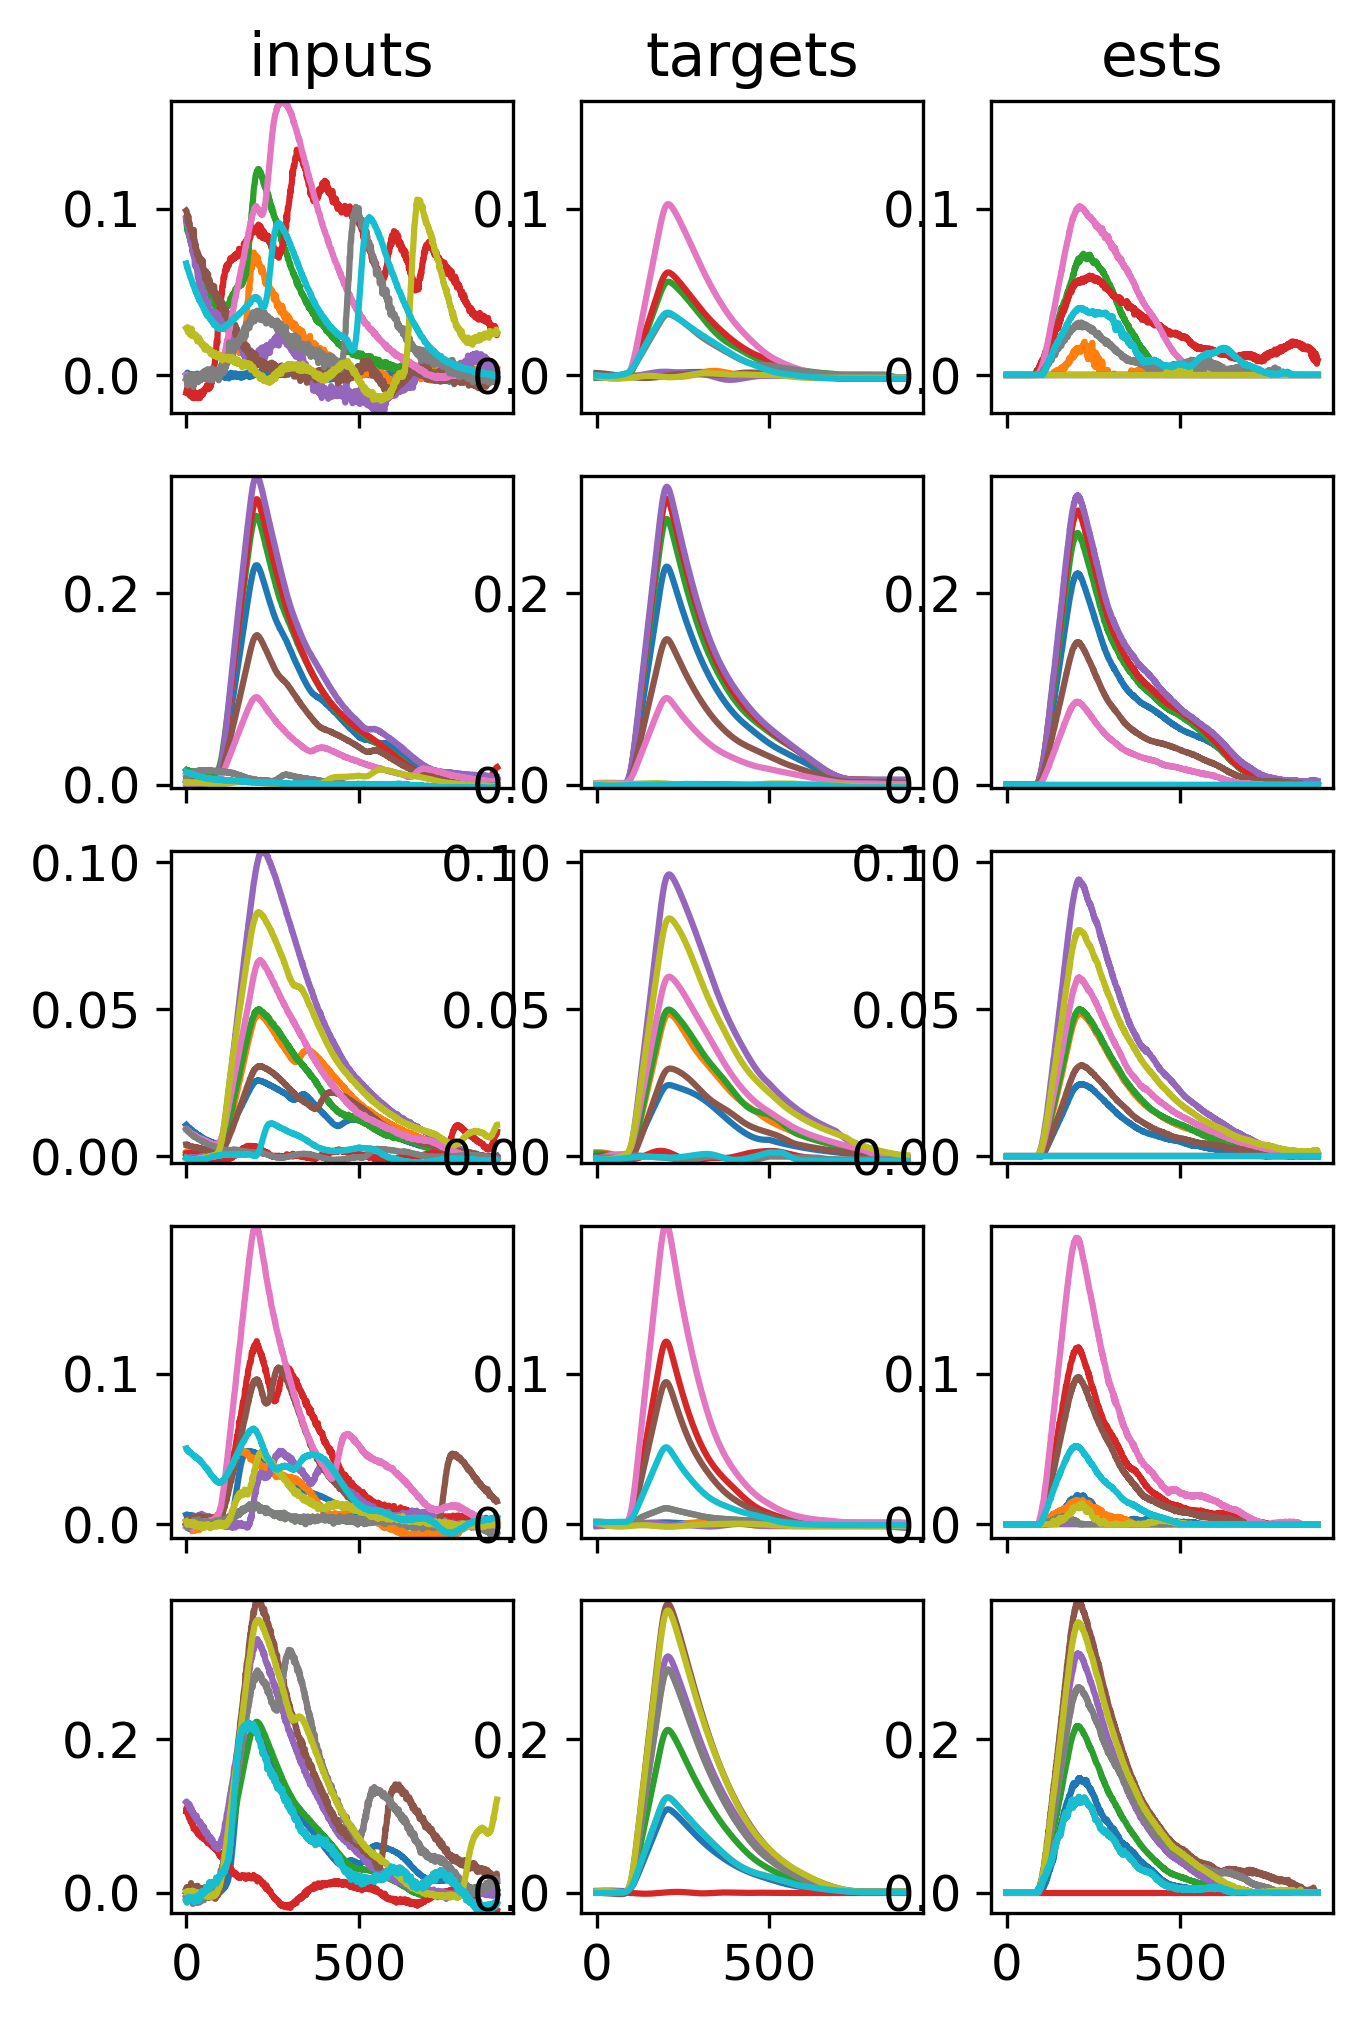

In [100]:
fig = viz_network_performance_synthetic(pc_subtractr)

# Real data


In [95]:
import glob
data_path = '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/'
files = glob.glob(data_path + '*.npz')
print(files)

['../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220308_B6_Chrome2fGC8_030822_Cell2_opsPositive_A_grid.npz', '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220314_WT_Chrome2fGC8_IV_031422_MultispotGrid_Cell3_opsPositive_A_planes.npz', '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220308_B6_Chrome2fGC8_030822_Cell1_OpsPositive_A_grid.npz', '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220308_B6_Chrome2fGC8_030822_Cell1_OpsPositive_A_planes.npz', '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220314_WT_Chrome2fGC8_IV_031422_MultispotGrid_Cell1_opsPositive_A_grid.npz', '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220308_B6_Chrome2fGC8_030822_Cell2_opsPositive_A_planes.npz', '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220314_WT_Chrome2fGC8_IV_031422_MultispotGrid_Cell3_opsPositive_A_grid.npz', '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220314_WT_Chrome2fGC8_IV_031422_MultispotGrid_Cell

In [96]:
expts = []
for file in files:
    dat = np.load(file, allow_pickle='True')
    raw_pscs = dat['psc']
    expts.append(raw_pscs)

Running photocurrent removal...complete (elapsed time 1.54s, device=cpu).
Running photocurrent removal...complete (elapsed time 1.62s, device=cpu).
Running photocurrent removal...complete (elapsed time 1.49s, device=cpu).
Running photocurrent removal...complete (elapsed time 1.47s, device=cpu).
Running photocurrent removal...complete (elapsed time 1.47s, device=cpu).
Running photocurrent removal...complete (elapsed time 1.51s, device=cpu).
Running photocurrent removal...complete (elapsed time 1.48s, device=cpu).
Running photocurrent removal...complete (elapsed time 1.47s, device=cpu).


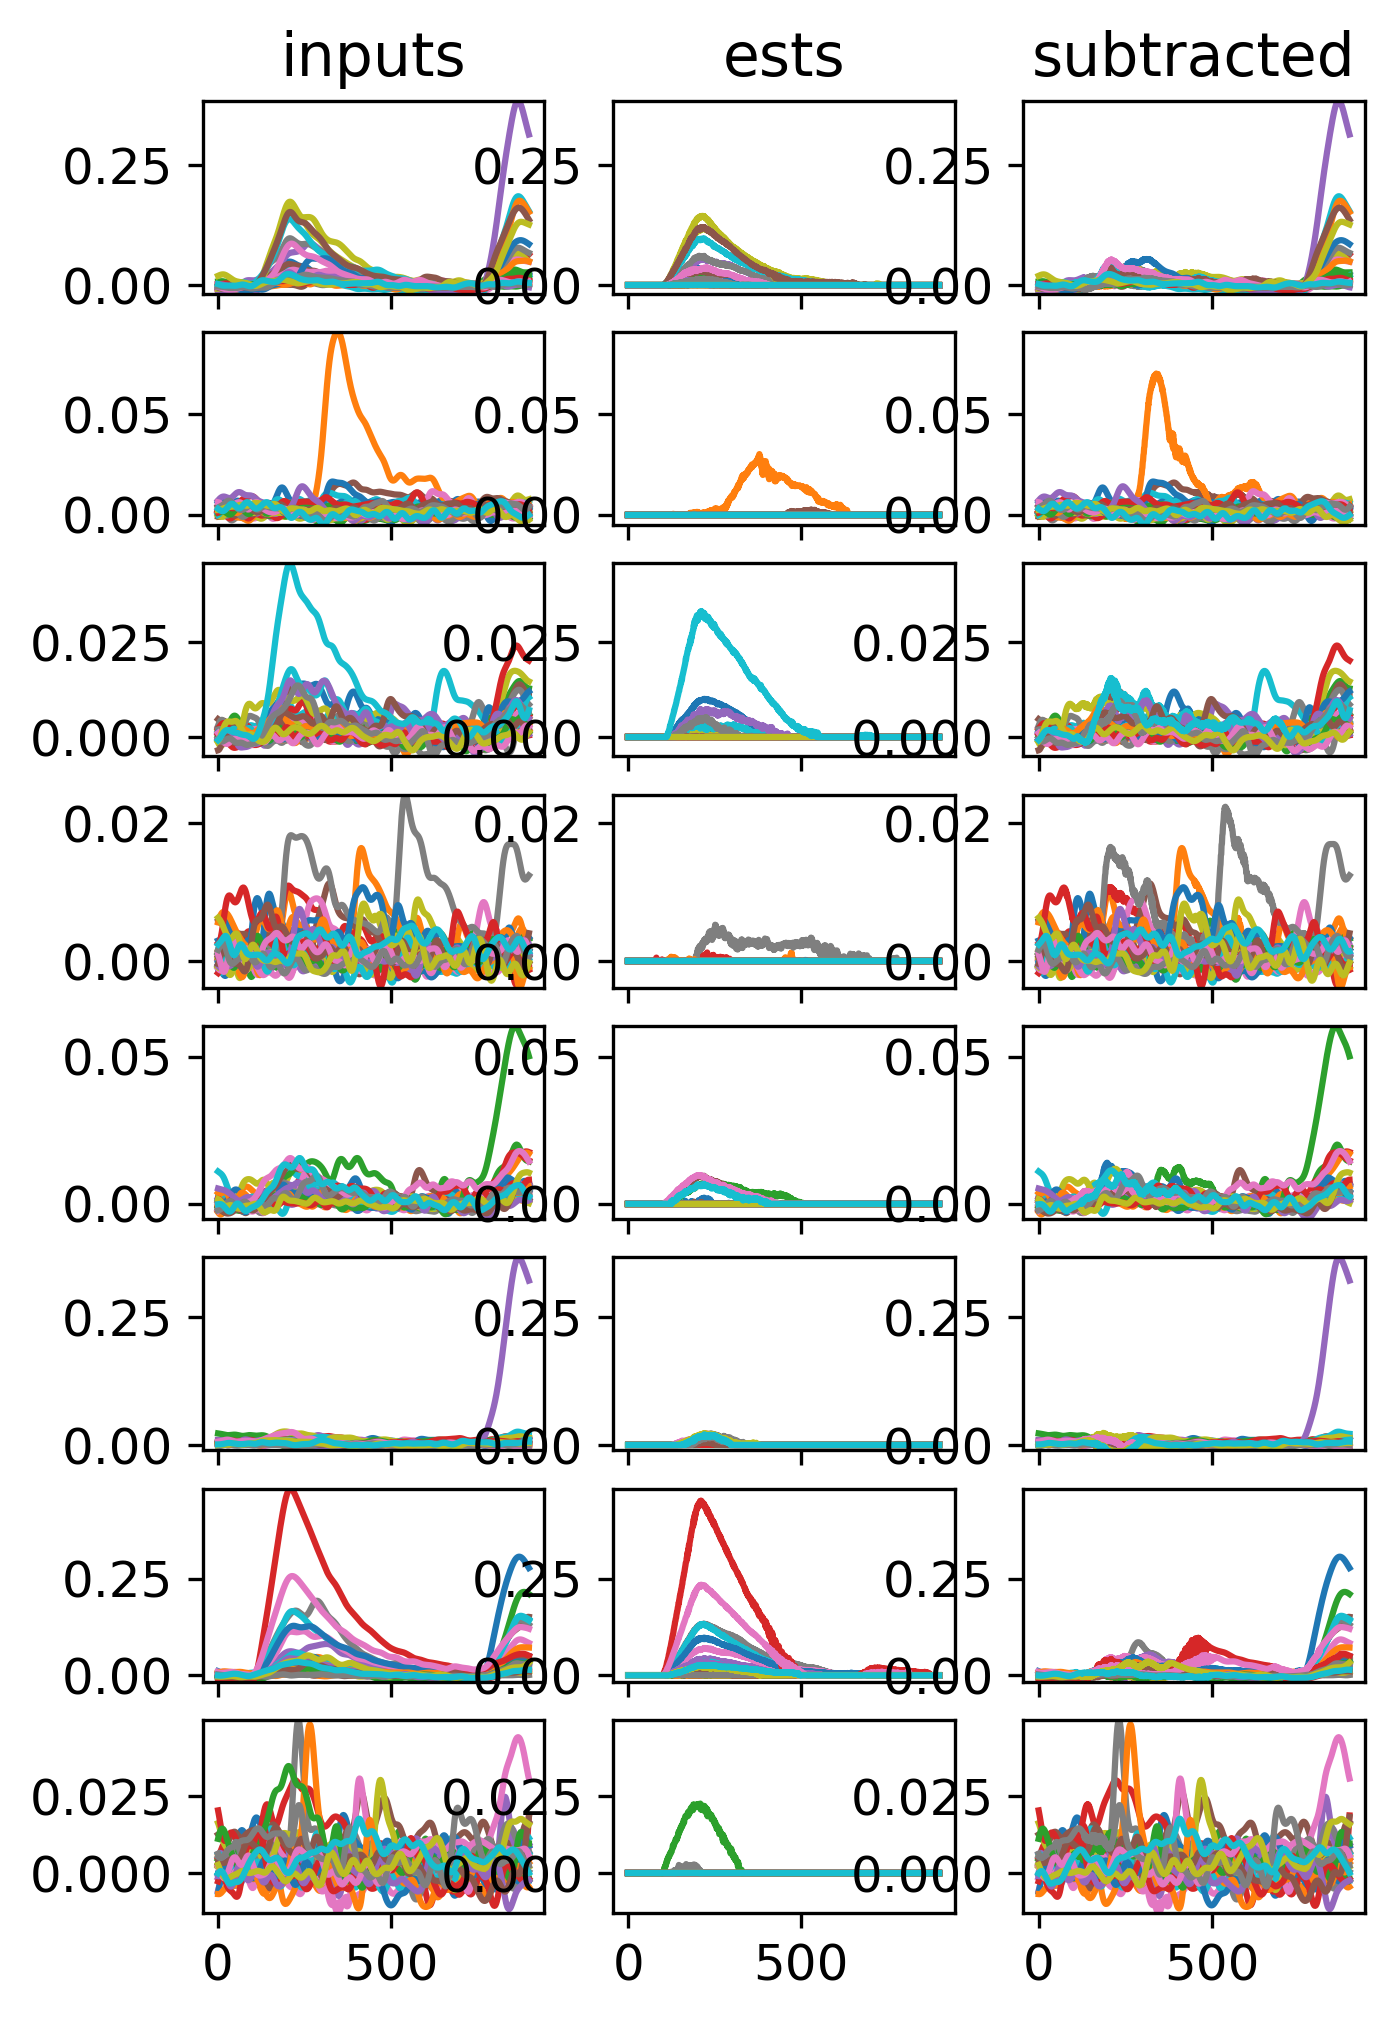

In [98]:
fig = viz_network_performance_real(pc_subtractr, expts, num_input_traces=1000, num_plot_traces=30)

In [9]:
[np.max(x) for x in expts]

[0.673734419455269,
 0.1355876792486013,
 0.06159976489991291,
 0.7380659251985396,
 1.0654873718981546,
 0.2594883343354001]